# Sensitivity of advanced gravitational-wave detectors

In this notebook we'll look into the famous sensitivity plot you will often see. For this we will use roughly similar noises as the current detectors such as Advanced LIGO and Advanced Virgo. Our results will not be exactly the same as the official plots, however this should give you an appreciation of the steps involved in how to compute the sensitivity.

**After this notebook you will be able to**:

* compute the response of a GW detector to gravitational-wave signals
* compute the frequency-noise limited sensitivity
* compute the quantum-noise limited sensitivity
* read and explain a sensitivity curve

**This notebook assumes you know:**
* What a transfer function is
* What a signal-to-noise ratio means
* What amplitude and power spectral densities are
* How to run and create Finesse 3 models

In [1]:
import finesse
import matplotlib.pyplot as plt
import numpy as np
finesse.init_plotting()

## How to model a transfer function
### Example: laser amplitude oscillations $\to$ photodiode output

For this example, we'll inject a signal into the laser amplitude and measure the output signal on a photodiode.

We'll start with the following model of a laser and an stretch of empty space:

In [2]:
base = finesse.Model()

base.parse("""
l laser P=2                 # Laser with 2W power
s s1 laser.p1 nada.p1 L=1   # Space of 1m length
nothing nada                # Connect the space to nothing
""")

To model a transfer function in Finesse there is a specfic recipe you must follow.
The steps of this recipe are:
1. **Set to a signal simulation:** Add an `fsig(1)` command to tell Finesse to run a signal simulation. This creates a signal called `fsig` with an initial frequency of $1$ Hz.
2. **Apply an input signal:** Add a signal generator `sgen` to the injection node, e.g., `sgen sig laser.amp`, which injects the signal into the laser amplitude.
3. **Measure the output signal:** Add a detector to demodulate this signal, e.g. `pd1 tf s1.p1.i f=fsig.f`. This measures the signal we added before.
4. **Sweep the frequency of the input signal:** To scan the signal frequency we can use `xaxis(fsig.f, log, 1e4, 1e9, 1000)`. This allows us to see how our detector responds to different frequencies.

In the following example, we compute how laser amplitude noise affects a photodiode output.

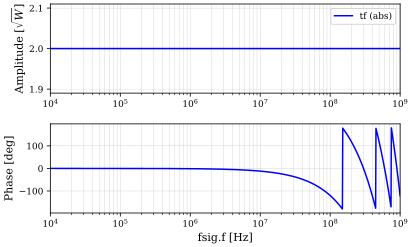

In [3]:
ifo = base.deepcopy()

ifo.parse("""
# 1. Set to signal simulation
fsig(1)

# 2. Apply an input signal
sgen sig laser.amp

# 3. Measure the output signal
pd1 tf nada.p1.i f=fsig.f

# 4. Sweep the frequency of the input signal
xaxis(fsig.f, log, 1e4, 1e9, 1000)
""")

out = ifo.run()

out.plot(logx=True);

This plot shows the magnitude and phase of the transfer function, but in arbitrary units. The real units of the transfer function to a power detector are always Watts per `X`, where `X` is the units of the thing we are modulating. 

In this example we are modulating the amplitude, so `X` = $\sqrt{W}$. The magnitude for this transfer function is flat, because there is no frequency dependence between the laser and the photodiode, it's just free space between them.

### Multiple injections

In Finesse 3 you can use multiple `sgen` components at once in a simulation. This is useful when you have two effects happening at once. For example, a differential motion of the mirrors in the arms of a detector are being moved at the same time but out of phase with each other, as one moves in one direction, the other mirror moves in the opposite. This signal can be described with the following two `sgen` commands:

```
sgen sig1 MX.z amplitude=1 phase=0
sgen sig2 MY.z amplitude=1 phase=180
```

This would shake mirrors (i.e., modulate their position along the optical axis) `MX` and `MY` but out of phase by 180 degrees.)

### Options for signal injection

This should be used as a reference for the tasks. It tells you what parameters can be modulated.

<table>
    <th>
        <td>**Component**</td>
        <td>**Target**</td>
        <td>**Unit**</td>
        <td>**Description**</td>
    </th>
    <tr>
        <td></td>
        <td>Mirror/Beamsplitter</td>
        <td>`mech.z`</td>
        <td>`W/m`</td>
        <td>Mirror tuning modulation</td>
    </tr>
    <tr>
        <td></td>
        <td>Laser</td>
        <td>`frq`</td>
        <td>`W/Hz`</td>
        <td>Modulates laser frequency</td>
    </tr>
    <tr>
        <td></td>
        <td>Laser</td>
        <td>`phs`</td>
        <td>`W/deg`</td>
        <td>Modulates laser phase</td>
    </tr>
    <tr>
        <td></td>
        <td>Laser</td>
        <td>`amp`</td>
        <td>`W/sqrt{W}`</td>
        <td>Modulates laser amplitude</td>
    </tr>
    <tr>
        <td></td>
        <td>Space</td>
        <td>`h`</td>
        <td>`W/h`</td>
        <td>Modulates the optical phase for a<br/>gravitational wave strain of `h`</td>
    </tr>
</table>

## Advanced detector model

Here we provide the Finesse code for a simplified Advanced detector roughly based on the Advanced LIGO parameters, use this for all the tasks below.
You should look at the commands and nodes and ** draw a sketch of the optical layout ** to understand how the components are connected together. 

In [4]:
base = finesse.Model()

base.parse(""" 
l LI P=125
s s1 LI.p1 PRM.p1 L=0

# Power recycling mirror
m PRM T=0.03 L=37.5u phi=90
s prc PRM.p2 bs1.p1 L=53

# Central beamsplitter
bs bs1 R=0.5 T=0.5 phi=0 alpha=45

# X-arm
s sx bs1.p3 ITMX.p1 L=4.5
m ITMX T=0.014 L=37.5u phi=89.997
s Lx ITMX.p2 ETMX.p1 L=3995
m ETMX T=0 L=37.5u phi=89.997

# Y-arm
s sy bs1.p2 ITMY.p1 L=4.45
m ITMY T=0.014 L=37.5u phi=3m
s Ly ITMY.p2 ETMY.p1 L=3995
m ETMY T=0 L=37.5u phi=3m

# Signal recycling mirror
s src bs1.p4 SRM.p1 L=50.525
m SRM T=0.2 L=37.5u phi=-90

# These commands give the mirrors a mass
# by default they are infinitely heavy
free_mass ITMX_sus ITMX.mech mass=40
free_mass ETMX_sus ETMX.mech mass=40
free_mass ITMY_sus ITMY.mech mass=40
free_mass ETMY_sus ETMY.mech mass=40
""") 

## Task 1: The gravitational-wave signal

We now get to the stage we can model how a gravitational-wave signal would appear in our detector. The gravitational wave will modulate the phase of the light travelling along a space. We can apply this type of signal to a space component in Finesse 3 using: `sgen sig1 space.h`.

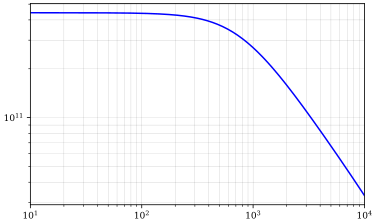

In [5]:
# Computes the gravitational wave signal transfer function to the output of a detector.    

# specifying our frequency range for future use
fstart = 10
fstop = 1e4
Npoints = 200

# This makes a copy of the model so we can add new commands to it
# without changing the original, which we will reuse
ifo = base.deepcopy() 

# Here we add our new code to compute a transfer function
ifo.parse(f"""
fsig(1)

sgen sig1 Ly.h 1 0
sgen sig2 Lx.h 1 180

pd1 TF SRM.p2.o f=fsig.f

xaxis(fsig.f, log, {fstart}, {fstop}, {Npoints})
""")

out = ifo.run() 
    
# We store the frequency and magnitude of the transfer function [W/h]
# (In general we need to store the magnitude and phase of the transfer 
# functions but we only need the magniture for these examples.)
f, Hs = out.x1, np.abs(out['TF'])

plt.loglog(f, Hs);

The units of this transfer function are $W/h$ where $h$ is the gravitational wave strain. The strain value will typically be something very small, $h \sim 10^{-23}$.

Does this transfer function tell you that the detector is more susceptible to low or high frequency gravitational waves?

The magnitude of the transfer function drops off as we go to higher frequencies, can you think why this is?

## Task 2: Mirror motion to output port transfer function - seismic noise

In this tasks we will model how the motion of a mirror appears in the output detector. This is an important transfer function, as many sources of noise will move the mirrors individually. For example, seismic noise from will shake the mirrors in the detectors, or thermal noise motion of the mirror surface. Typically, these noises are **not coherent** between all the mirrors, so you must add up the noise from each of the arm cavity mirrors. 

To compute the seismic noise limited sensitivity you must calculate:

$$S_s(f) = \frac{N_s(f) |H_m(f)|}{|H_s(f)|}$$

where $S_s(f)$ is the __equivalent strain amplitude spectral density from seismic noise__, $N_s(f)$ is the motion in meters of the mirror, $H_m(f)$ is the transfer function from the mirror to the output detector, and $H_s(f)$ is the transfer function of the gravitational wave signal. This value tells you how much a particular noise appears to look like a gravitational wave signal, thus limits our sensitivity. The units of this work out as:

$$\frac{[m/\sqrt{Hz}] [W/m]}{[W/h]} = \frac{h}{\sqrt{Hz}}$$

which is the __equivalent strain amplitude spectral density from seismic noise__.

The seismic noise will shake the two end and input mirrors separately. We need to compute the transfer functions in units of [W/m] for:
- `ETMX` mirror to the output port
- `ETMY` mirror to the output port
- `ITMX` mirror to the output port
- `ITMY` mirror to the output port

We then compute and plot the __equivalent strain amplitude spectral density from seismic noise__.

In [6]:
# We can write a function to model a transfer function from different inputs 
# to keep our code compact. We use the table above to find the `fsig` command to 
# modulate the mirror position in units of [W/m].

# Computer transfer function from a specific input node to a photo detector in the 
# main interferometer outout
def get_TF(base, input_node):
    ifo = base.deepcopy()
    ifo.parse(f"""
    fsig(1)
    sgen sig1 {input_node} 1 0
    pd1 TF SRM.p2.o f=fsig.f
    xaxis(fsig.f, log, {fstart}, {fstop}, {Npoints})
    """)
    return ifo.run()

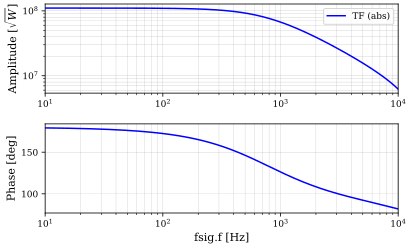

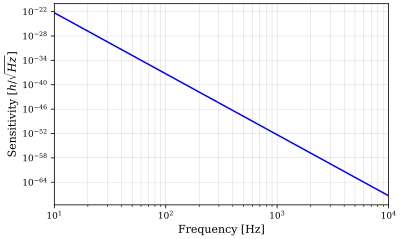

In [7]:
# Now compute the transfer functions for 4 mirrors
mirrors = ['ETMX', 'ETMY', 'ITMX', 'ITMY']
tfs = np.empty([len(mirrors),len(f)])

for i,m in enumerate(mirrors):
    # get mirror TF
    out = get_TF(base, f'{m}.mech.z')
    tfs[i]=np.abs(out['TF'])

# Plotting one TF to see how it looks
out.plot(log=True);

# We compute an expected frequency spectrum of the mirror motion along the optical axis 
# due to seismic noise using this simple model (note that this is an arbitrary noise
# spectrum for demonstration purposed and does not represent any actual noise measurement.)
def seismic_noise_ASD(f):
    f = np.array(f)
    N = 1e-4/np.abs(np.random.normal(f**15, 0, size=f.size))
    return N

N_s_asd = seismic_noise_ASD(f)

# Computing the seismic noise limited sensitivity.
# (adding amplitude spectral densities A, B, and C, works as sqrt(A^2 + B^2 + C^2).
sum = 0
for tf in tfs:
    sum += (N_s_asd * tf / Hs)**2
S_s = np.sqrt(sum)

# Plotting the 'seismic-limited sensitivity'
plt.figure()
plt.loglog(f, S_s)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Sensitivity [$h/\sqrt{Hz}$]");

## Task 3: Coating thermal noise

Now using the same mirror motion transfer functions we can compute the thermal noise limited sensitivity. For this we simply need the motion of the mirror due to thermal noise instead of seismic. 

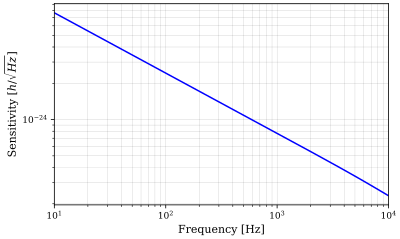

In [8]:
# A simple model for thermal noise, again only used 
def thermal_noise_ASD(f):
    """
    Based on https://arxiv.org/pdf/gr-qc/0109073.pdf equation 24
    """
    kb = 1.38064852e-23
    T = 300
    Y = 7e10
    d = 5e-6
    w = 5e-2
    phi = 1e-5
    phi_s = 1e-8
    return np.sqrt(2*kb * T/((np.pi)**(3/2)*f) * (1/(w*Y))* (phi_s + 1/np.sqrt(np.pi) * d/w * 2* phi ))/np.sqrt(2)

N_t_asd = thermal_noise_ASD(f)

# Here we compute the seismic noise limited sensitivity
sum = N_t_asd * 0.0
for tf in tfs:
    sum += (N_t_asd * tf / Hs)**2
S_t = np.sqrt(sum)

plt.figure()
plt.loglog(f, S_t)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Sensitivity [$h/\sqrt{Hz}$]");

## Task 4: Quantum noise on the sensitivity plot

"Quantum noise" is an umbrella term used to refer to multiple complicated effects in the interferometer. However, they are all a direct consequence of the photonic nature of the light field, their associated Poissonian statistics, and the Heisenberg uncertainty principle. The details are unimportant for our modeling tasks, but the interested reader may find this [review article](https://arxiv.org/abs/1203.1706) informative.


In Finesse 3 the `qnoised` detector can be used to directly compute the quantum noise amplitude spectral density at the output port of an interferometer.

The output of `qn` has the form $N_q(f) |H_p(f)|$, where $N_q$ is the amplitude spectral density of the quantum noise and $H_p$ the transfer function from quantum noise to the output port, so 
we can then directly combine this output with the transfer function computed in task 1 to get the *Quantum Noise Limited Sensitivity* of the interferometer:
$S_q(f) = \frac{\mathtt{out[`qn`]}}{|H_s(f)|}$

The finesse syntax you will need is
```
fsig noise 1
qnoised qn 1 $fs nout
xaxis noise f log 1 100k 1000
```

where the `xaxis` range should be the same as you have used in each of the previous tasks.

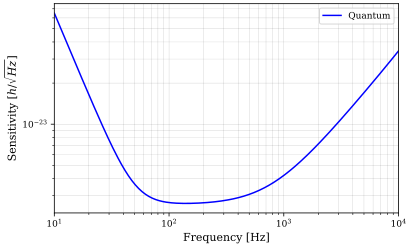

In [9]:
ifo = base.deepcopy()
ifo.parse(f"""
fsig(1)
# Here we compute the quantum-noise limited sensitivity
qnoised qn SRM.p2.o
xaxis(fsig.f, log, {fstart}, {fstop}, {Npoints})
""")
#ifo.LI.P=10
out = ifo.run()
S_q = out['qn'] / Hs

plt.loglog(f, S_q, label="Quantum")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Sensitivity [$h/\sqrt{Hz}$]")
plt.legend()
plt.tight_layout();

From the above plot we see a bucket like shape, at high frequencies we are limited by **shot noise**.
At low frequencies we are dominated by **radiation pressure noise**. Shot noise is typically improved by increasing power. However, increased power means more radiation pressure noise. You can see how this behaves by replotting the above using different input laser powers.

Now we can construct a noise budget by plotting on the same graph:
- The quantum noise limited sensitivity
- The thermal noise limited sensitivity
- The seismic noise limited sensitivity
- The sum of these three noises to get the total sensitivity

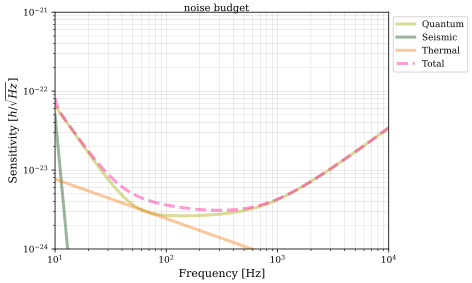

In [10]:
#all curves together:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.loglog(f, S_q, label="Quantum", alpha=0.4, color='xkcd:puke', linewidth=3)
ax.loglog(f, S_s, label="Seismic",alpha=0.4, color='xkcd:forest green', linewidth=3)
ax.loglog(f, S_t, label="Thermal",alpha=0.4, color='xkcd:orange', linewidth=3)

total = np.sqrt(S_q**2 + S_s**2 + S_t**2)
ax.loglog(f, total, label="Total", alpha=0.4, color='xkcd:electric pink', linewidth=3, linestyle='--')

ax.set_ylim(1e-24, 1e-21)
ax.legend(loc=2,bbox_to_anchor=(1,1))
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Sensitivity [$h/\sqrt{Hz}$]")
fig.suptitle('noise budget');
fig.subplots_adjust(top=0.95);

## Task 5: laser frequency noise 

We can also answer a different question using these transfer functions, for example: what are the requirements on the laser frequency noise

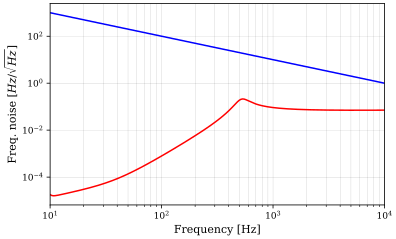

In [11]:

ifo = base.deepcopy()

out = get_TF(ifo, 'LI.frq')
Hn = np.abs(out['TF'])
#out.plot(log=True);

# Simple model of frequency noise (ultra-stable but free-running laser)
def frequency_noise_ASD(f):
    f = np.array(f)
    return 1e4/abs(np.random.normal(f, 0, size=f.size))
    
N_f = frequency_noise_ASD(f)

# The same equation as above but inverted to compute the frequency noise from 
# 'total', the sensitivity computed above.
S_f = (N_f * Hn) / Hs

N_f_req = total * Hs / Hn

plt.figure()
plt.loglog(f, N_f, label="free-runing laser noise")
plt.loglog(f, N_f_req, label="laser frequency noise requirement")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Freq. noise [$Hz/\sqrt{Hz}$]");